# Hyperparameter Tuning for Random Forest Training for Customer Churn Prediction

This Jupyter Notebook provides steps to preprocess the data, tune hyperparameters using Grid Search and Bayesian Optimization, and train a Random Forest model for customer churn prediction using the processed dataset.


## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load and Preprocess the Data

In [2]:
# Load the processed dataset
data_path = './enhanced_feature_data.csv' 
df = pd.read_csv(data_path)
df.drop(['tenure_bins'], axis=1, inplace=True)

# Define the feature columns and the target column
feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns]
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define Hyperparameters

In [3]:
# Categorical hyperparameters
categorical_params = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [4]:
# Continuous hyperparameters
continuous_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

## Grid Search for Categorical Hyperparameters

In [5]:
# Convert the continuous params to a default value for initial grid search
default_continuous_params = {k: [100 if 'n_estimators' in k else 10] for k in continuous_params.keys()}

In [6]:
# Combine categorical params with default continuous params
param_grid = {**categorical_params, **default_continuous_params}

In [7]:
# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [10], 'min_samples_split': [10],
                         'n_estimators': [100]},
             verbose=2)

In [8]:
# Get the best categorical hyperparameters
best_categorical_params = grid_search.best_params_
print(f'Best categorical parameters: {best_categorical_params}')

Best categorical parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


## Bayesian Optimization for Continuous Hyperparameters

In [9]:
# Update the continuous parameter space with the fixed best categorical hyperparameters
param_space = {**continuous_params}

# Initialize Bayesian Optimization with fixed categorical hyperparameters
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(**best_categorical_params, random_state=42),
    search_spaces=param_space,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,
    random_state=42
)

# Fit the model
bayes_search.fit(X_train, y_train)

# Get the best parameters
best_params = bayes_search.best_params_
print(f'Best parameters found by Bayesian Optimization: {best_params}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [10]:
combined_params = {**best_categorical_params, **best_params}

## Train a Model with Best Parameters

In [11]:
# Initialize the model with best parameters
best_model = RandomForestClassifier(**combined_params, random_state=42)

# Train the model
best_model.fit(X_train, y_train)

# Evaluate the Model
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.80
Precision: 0.67
Recall: 0.50
F1-Score: 0.57
ROC AUC: 0.70
Confusion Matrix:
[[944  92]
 [188 185]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



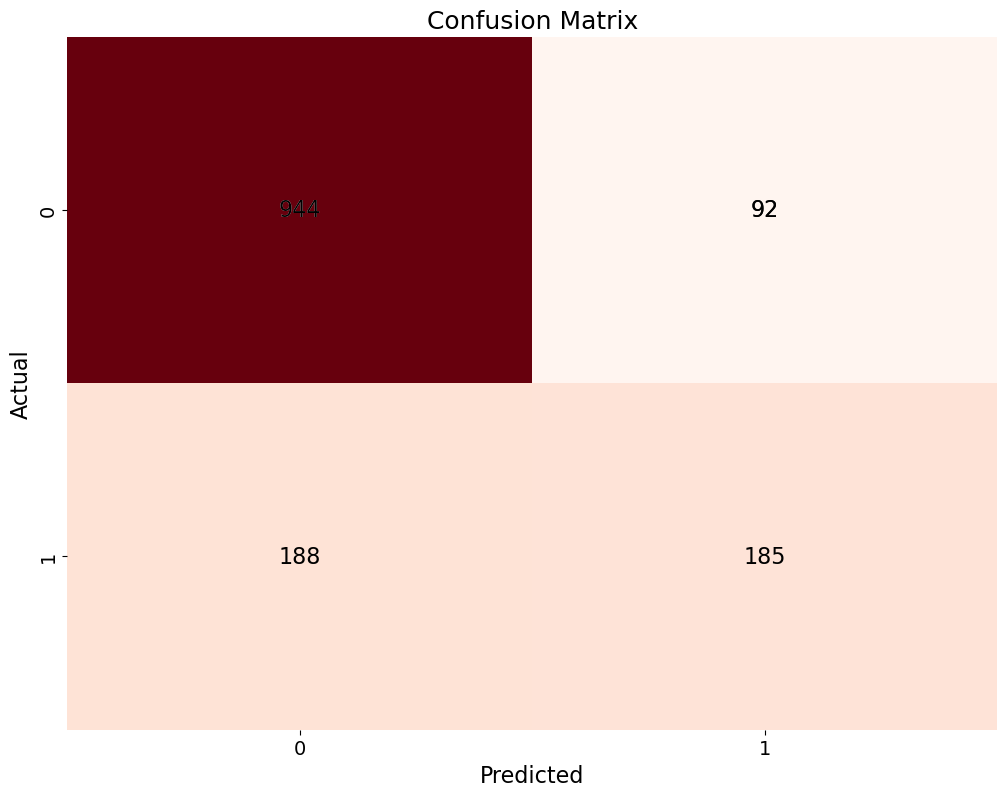

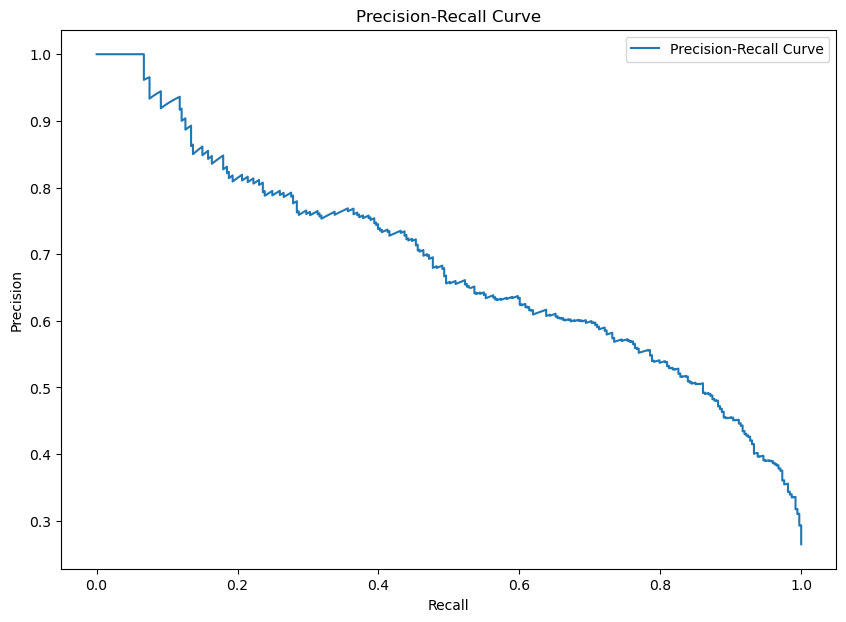

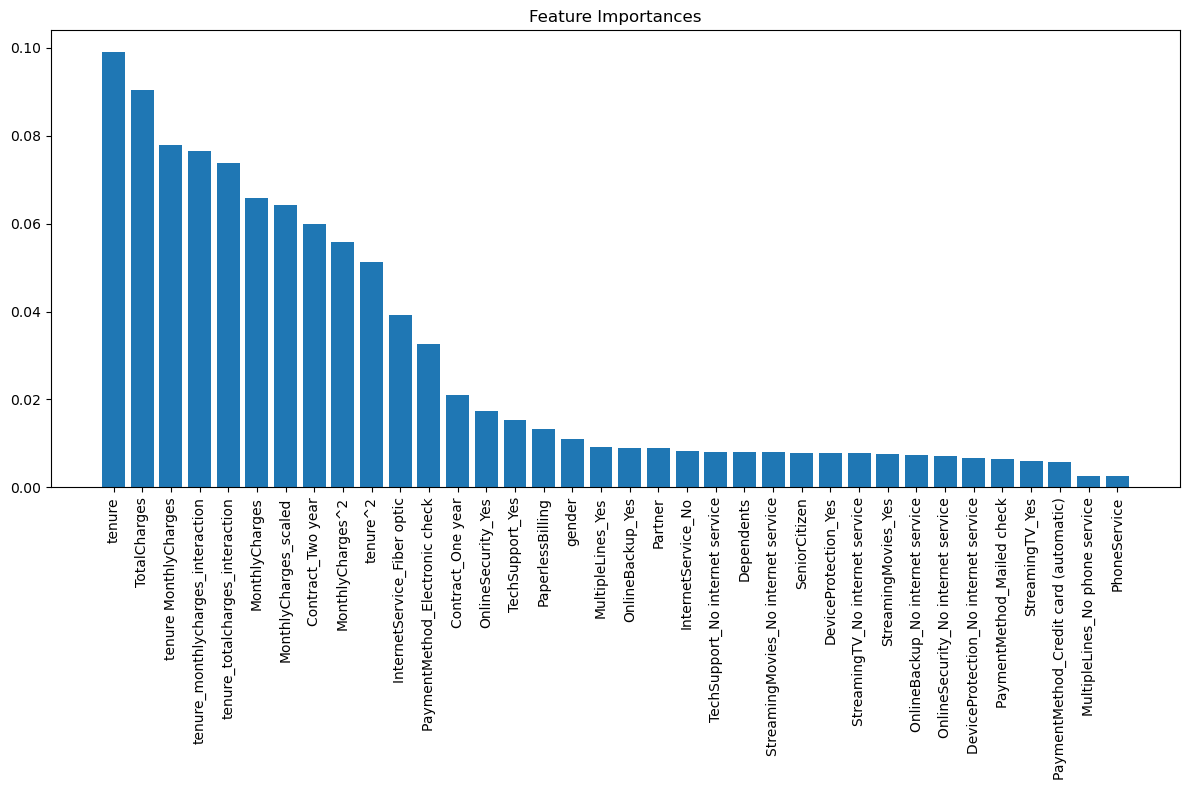

In [12]:
# Visualize Model Performance

# Confusion Matrix
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Precision-Recall Curve
C_precision, C_recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(C_recall, C_precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Feature Importances
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Save Results

In [13]:
# Save evaluation metrics to a text file
with open('./RandomForest_EvaluationMetrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.2f}\n')
    f.write(f'Precision: {precision:.2f}\n')
    f.write(f'Recall: {recall:.2f}\n')
    f.write(f'F1-Score: {f1:.2f}\n')
    f.write(f'ROC AUC: {roc_auc:.2f}\n')

# Save classification report to a text file
with open('./RandomForest_ClassificationReport.txt', 'w') as f:
    f.write(class_report)

# Save confusion matrix as an image
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./RandomForest_ConfusionMatrix.png')
plt.close()

## Save the model to a file

In [14]:
model_filename = 'best_churn_randomforest_combined_tuning.joblib'
joblib.dump(best_model, model_filename)

print(f'Model saved to {model_filename}')

Model saved to best_churn_randomforest_combined_tuning.joblib
